In [1]:
# ==============================================================================
# PASO 1: IMPORTACIÓN DE LIBRERÍAS
# ==============================================================================
import pandas as pd
import numpy as np
import joblib
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import yaml
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# La librería 'contextlib' nos permite manejar el logging de MLflow de forma opcional.
from contextlib import nullcontext

print("Librerías importadas exitosamente.")

Librerías importadas exitosamente.


In [2]:
# ==============================================================================
# PASO 2: CONFIGURACIÓN Y CARGA DE DATOS
# ==============================================================================

# Configuración de MLflow (opcional, si no está corriendo, el script funcionará igual)
mlflow_tracking_uri = 'http://localhost:5555' # Optional: e.g., 'http://localhost:5555'

# Carga de los datos preprocesados del notebook anterior
print("\nCargando los conjuntos de datos de entrenamiento y prueba procesados...")
try:
    X_train = pd.read_csv('../data/processed/X_train.csv')
    X_test = pd.read_csv('../data/processed/X_test.csv')
    y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
    y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()
    print("Datos cargados exitosamente.")
except FileNotFoundError:
    print("ERROR: Archivos no encontrados. Asegúrate de haber ejecutado el notebook '02_feature_engineering.ipynb' primero.")
    exit()

print(f"Características de entrenamiento: {X_train.shape}")
print(f"Características de prueba: {X_test.shape}")


Cargando los conjuntos de datos de entrenamiento y prueba procesados...
Datos cargados exitosamente.
Características de entrenamiento: (61, 13)
Características de prueba: (16, 13)


In [3]:
# ==============================================================================
# PASO 3: DEFINICIÓN DE MODELOS Y PARÁMETROS PARA GRIDSEARCH
# ==============================================================================
print("\nDefiniendo los modelos y sus grillas de hiperparámetros...")

# Diccionario de modelos a evaluar
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Grillas de parámetros para GridSearchCV. Para los modelos lineales, la grilla está vacía.
# Se han reducido ligeramente las combinaciones para una ejecución más rápida en esta fase inicial.
param_grids = {
    'LinearRegression': {},
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0]
    },
    'RandomForest': {
        'n_estimators': [100, 150],
        'max_depth': [10, 20, None]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
}
print("Modelos y grillas de hiperparámetros definidos.")



Definiendo los modelos y sus grillas de hiperparámetros...
Modelos y grillas de hiperparámetros definidos.


In [4]:
# ==============================================================================
# PASO 4: FUNCIÓN DE EVALUACIÓN
# ==============================================================================

def evaluate_model(model_name, model, params, X_train, y_train, X_test, y_test):
    """
    Entrena un modelo usando GridSearchCV si se proveen parámetros, 
    y devuelve las métricas y el mejor modelo.
    """
    if params:
        grid_search = GridSearchCV(model, params, cv=3, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Mejores parámetros para {model_name}: {grid_search.best_params_}")
        print(f"Mejor score de validación cruzada (R²) para {model_name}: {grid_search.best_score_:.4f}")
        print(f"Score en el conjunto de prueba (R²) para {model_name}: {best_model.score(X_test, y_test):.4f}")
    else:
        model.fit(X_train, y_train)
        best_model = model
        print(f"No se realizó GridSearchCV para {model_name} ya que no se proporcionaron parámetros.")
        print(f"Score en el conjunto de prueba (R²) para {model_name}: {best_model.score(X_test, y_test):.4f}")
        

    # Predicción y cálculo de métricas
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return {
        'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2,
        'model': best_model, 'params': best_model.get_params()
    }


print("MLflow tracking URI:", mlflow_tracking_uri)

MLflow tracking URI: http://localhost:5555


In [5]:
# ==============================================================================
# PASO 5: CICLO DE EXPERIMENTACIÓN CON MLFLOW
# ==============================================================================
print("\nIniciando ciclo de experimentación...")

# Configurar el experimento en MLflow
try:
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    mlflow.set_experiment("House Price Prediction - Baseline")
    mlflow_enabled = True
    print(f"MLflow configurado y registrando en: {mlflow_tracking_uri}")
except:
    mlflow_enabled = False
    print("Advertencia: No se pudo conectar a MLflow. El script continuará sin registrar los experimentos.")

# Diccionario vacío para almacenar los resultados de cada modelo.
results = {}

# El 'with' asegura que la ejecución principal de MLflow se cierre correctamente
with mlflow.start_run(run_name="Model_Baseline_Comparison") if mlflow_enabled else nullcontext() as parent_run:
    
    # Iteramos sobre cada modelo
    for name, model in models.items():
        print(f"\n--- Entrenando y evaluando: {name} ---")
        
        # El 'with' anidado crea una ejecución hija para cada modelo
        with mlflow.start_run(run_name=name, nested=True) if mlflow_enabled else nullcontext() as child_run:
            
            # Evaluar el modelo y obtener métricas
            evaluation = evaluate_model(name, model, param_grids[name], X_train, y_train, X_test, y_test)
            results[name] = evaluation

            # Registrar en MLflow si está habilitado
            if mlflow_enabled:
                # Registrar parámetros, métricas y el modelo
                mlflow.log_params(evaluation['params'])
                mlflow.log_metrics({
                    'mae': evaluation['mae'],
                    'mse': evaluation['mse'],
                    'rmse': evaluation['rmse'],
                    'r2': evaluation['r2']
                })
                mlflow.sklearn.log_model(evaluation['model'], name=name)

            print(f"Resultados para {name} -> R2: {evaluation['r2']:.4f}, RMSE: ${evaluation['rmse']:,.2f}")

print("\nCiclo de experimentación completado.")


Iniciando ciclo de experimentación...
MLflow configurado y registrando en: http://localhost:5555

--- Entrenando y evaluando: LinearRegression ---
No se realizó GridSearchCV para LinearRegression ya que no se proporcionaron parámetros.
Score en el conjunto de prueba (R²) para LinearRegression: 0.9908


2025/10/05 22:11:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Resultados para LinearRegression -> R2: 0.9908, RMSE: $20,742.67
🏃 View run LinearRegression at: http://localhost:5555/#/experiments/1/runs/85651f7590714fcdbb659d3e9494dc2e
🧪 View experiment at: http://localhost:5555/#/experiments/1

--- Entrenando y evaluando: Ridge ---
Mejores parámetros para Ridge: {'alpha': 0.1}
Mejor score de validación cruzada (R²) para Ridge: 0.9984
Score en el conjunto de prueba (R²) para Ridge: 0.9924


2025/10/05 22:11:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Resultados para Ridge -> R2: 0.9924, RMSE: $18,754.66
🏃 View run Ridge at: http://localhost:5555/#/experiments/1/runs/b23838feca91412e973e798c11bbd865
🧪 View experiment at: http://localhost:5555/#/experiments/1

--- Entrenando y evaluando: RandomForest ---
Mejores parámetros para RandomForest: {'max_depth': 10, 'n_estimators': 100}
Mejor score de validación cruzada (R²) para RandomForest: 0.9926
Score en el conjunto de prueba (R²) para RandomForest: 0.9852


2025/10/05 22:11:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Resultados para RandomForest -> R2: 0.9852, RMSE: $26,277.27
🏃 View run RandomForest at: http://localhost:5555/#/experiments/1/runs/16d837dc0a254453bc634aab398fea56
🧪 View experiment at: http://localhost:5555/#/experiments/1

--- Entrenando y evaluando: GradientBoosting ---
Mejores parámetros para GradientBoosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Mejor score de validación cruzada (R²) para GradientBoosting: 0.9954
Score en el conjunto de prueba (R²) para GradientBoosting: 0.9824


2025/10/05 22:11:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Resultados para GradientBoosting -> R2: 0.9824, RMSE: $28,636.76
🏃 View run GradientBoosting at: http://localhost:5555/#/experiments/1/runs/dc1378b15e0b4f1cac6c3365c4123525
🧪 View experiment at: http://localhost:5555/#/experiments/1

--- Entrenando y evaluando: XGBoost ---
Mejores parámetros para XGBoost: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Mejor score de validación cruzada (R²) para XGBoost: 0.9785
Score en el conjunto de prueba (R²) para XGBoost: 0.9738


2025/10/05 22:11:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Resultados para XGBoost -> R2: 0.9738, RMSE: $34,904.30
🏃 View run XGBoost at: http://localhost:5555/#/experiments/1/runs/115c03b53fb04824b8c1cea8e03b99b6
🧪 View experiment at: http://localhost:5555/#/experiments/1
🏃 View run Model_Baseline_Comparison at: http://localhost:5555/#/experiments/1/runs/93039f6820134af1822f02914ed503bb
🧪 View experiment at: http://localhost:5555/#/experiments/1

Ciclo de experimentación completado.



--- Resumen y Comparación de Resultados ---
Tabla de resultados de la línea base:
                           mae           mse          rmse        r2
Ridge              8315.990023  3.517373e+08  18754.660164  0.992449
LinearRegression   8563.775710  4.302584e+08  20742.671701  0.990763
RandomForest      13263.125000  6.904951e+08  26277.273332  0.985176
GradientBoosting  15755.317568  8.200641e+08  28636.760794  0.982394
XGBoost           20988.189453  1.218310e+09  34904.297959  0.973844


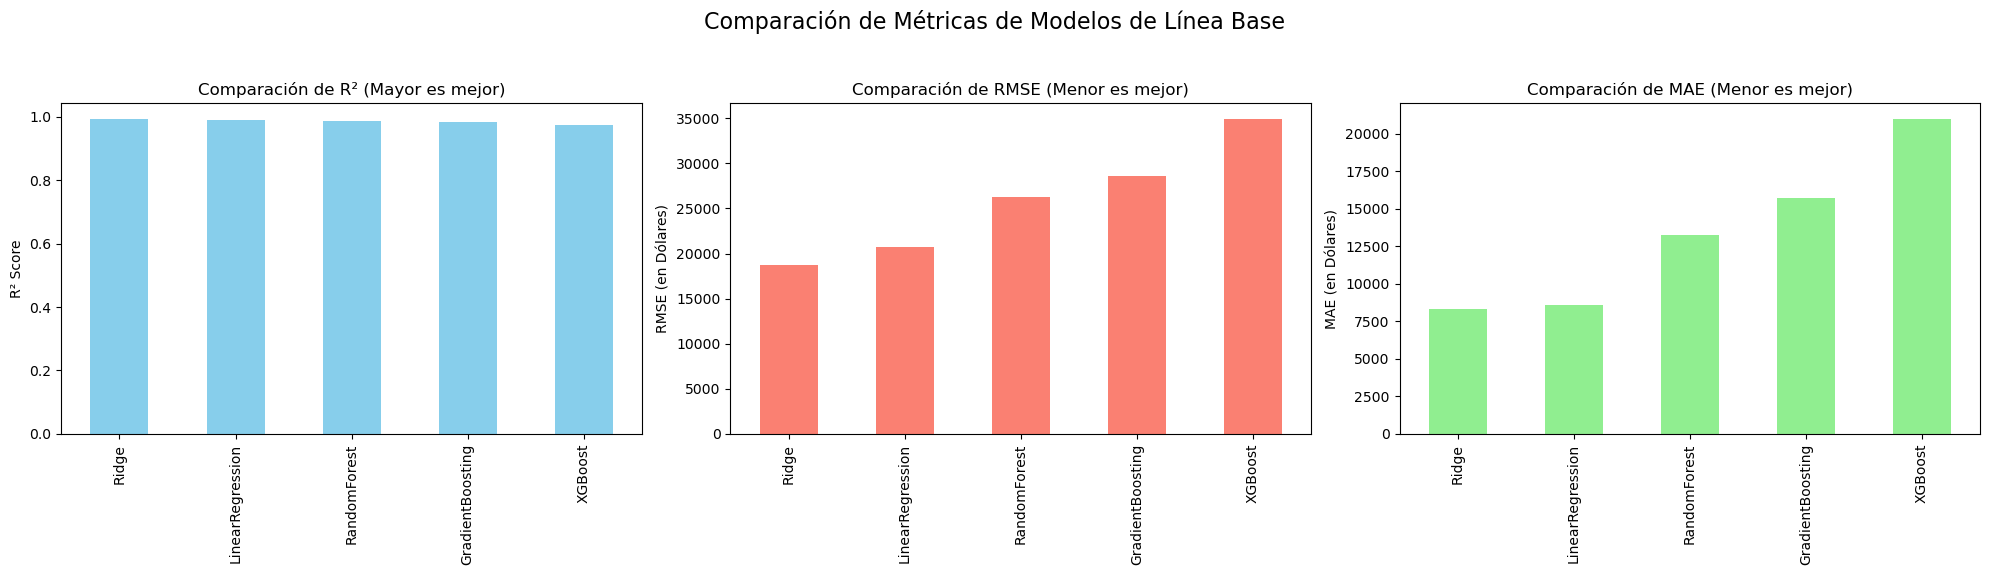


🏆 Mejor Modelo (basado en R²): Ridge
   - R² Score: 0.9924
   - MAE: $8,315.99
   - RMSE: $18,754.66

Configuración del mejor modelo de línea base guardada en: ../models/baseline_model_config.yaml

--- CONCLUSIÓN DEL EXPERIMENTO ---
El mejor modelo es: Ridge con R²: 0.9924, RMSE: $18,754.66


In [6]:
# ==============================================================================
# PASO 6: ANÁLISIS, VISUALIZACIÓN Y SELECCIÓN DEL MEJOR MODELO
# ==============================================================================
print("\n--- Resumen y Comparación de Resultados ---")

# Crear el DataFrame de resultados para análisis numérico
results_df = pd.DataFrame({
    model: {metric: value for metric, value in metrics.items() if isinstance(value, (int, float))}
    for model, metrics in results.items()
}).T.sort_values(by='r2', ascending=False)

print("Tabla de resultados de la línea base:")
print(results_df)

# --- Función de Visualización ---
def plot_model_metrics(results_df):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    results_df['r2'].sort_values(ascending=False).plot(kind='bar', ax=axes[0], color='skyblue', title='Comparación de R² (Mayor es mejor)')
    axes[0].set_ylabel('R² Score')
    results_df['rmse'].sort_values(ascending=True).plot(kind='bar', ax=axes[1], color='salmon', title='Comparación de RMSE (Menor es mejor)')
    axes[1].set_ylabel('RMSE (en Dólares)')
    results_df['mae'].sort_values(ascending=True).plot(kind='bar', ax=axes[2], color='lightgreen', title='Comparación de MAE (Menor es mejor)')
    axes[2].set_ylabel('MAE (en Dólares)')
    plt.suptitle('Comparación de Métricas de Modelos de Línea Base', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Graficar las métricas de los modelos
plot_model_metrics(results_df)

# Encontrar y guardar la configuración del mejor modelo
best_model_name = results_df['r2'].idxmax()
best_model_details = results[best_model_name]

print(f"\n🏆 Mejor Modelo (basado en R²): {best_model_name}")
print(f"   - R² Score: {best_model_details['r2']:.4f}")
print(f"   - MAE: ${best_model_details['mae']:,.2f}")
print(f"   - RMSE: ${best_model_details['rmse']:,.2f}")

# Crear el diccionario de configuración para el mejor modelo
model_config = {
    'best_model_name': best_model_name,
    'parameters': best_model_details['params'],
    'metrics': {
        'r2': best_model_details['r2'],
        'mae': best_model_details['mae'],
        'rmse': best_model_details['rmse']
    },
    'features': X_train.columns.tolist() # Guardamos la lista de características usadas
}

# Guardar la configuración del modelo ganador en un archivo YAML
config_path = '../models/baseline_model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    yaml.dump(model_config, f, default_flow_style=False)

print(f"\nConfiguración del mejor modelo de línea base guardada en: {config_path}")
print("\n--- CONCLUSIÓN DEL EXPERIMENTO ---")
print(f"El mejor modelo es: {best_model_name} con R²: {best_model_details['r2']:.4f}, RMSE: ${best_model_details['rmse']:,.2f}")